# Relax Data Science Challenge

In [49]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
#read in csv files as pandas dataframes
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [51]:
#Explore data
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [52]:
#explore data
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Note the missing values in last_session_creation_time and invited_by_user_id. Also note that all datetime columns are not of type datetime.

In [53]:
#explore data
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [54]:
#explore data
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Identify Adopted Users

In [55]:
#convert time stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [56]:
#extract week and year from time_stamp
engagement['week-year'] = engagement['time_stamp'].dt.strftime('%U-%Y')

In [57]:
#check dataframe
engagement.head()

,time_stamp,user_id,visited,week-year
0,2014-04-22 03:53:30,1,1,16-2014
1,2013-11-15 03:45:04,2,1,45-2013
2,2013-11-29 03:45:04,2,1,47-2013
3,2013-12-09 03:45:04,2,1,49-2013
4,2013-12-25 03:45:04,2,1,51-2013


In [58]:
#group by user and week and aggregate by count
usage = engagement.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

In [59]:
#if count is greater than or equal to 3, consider user to be an adopted user
usage['adopted'] = usage['count']>=3

In [60]:
#Extract list of adopted users
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [61]:
#add column in users df to identify adopted users. This is the target variable.
#if object_id is in the list of adopted users --> True. Else --> False.
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

## Drop Unnecessary Columns and Set Index

In [62]:
#drop columns and set index
users_clean = users.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')

In [63]:
users_clean.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


## Feature Engineering

In [64]:
#Look at the number of creation sources
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [65]:
#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)

In [66]:
#Convert creation_time and last_session_creation_time to datetime
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

In [67]:
#Extract months from datetime columns.
df['creation_month'] = df.creation_time.dt.month

df['last_session_creation_month'] = df.last_session_creation_time.dt.month

invited_by_user_id has many null values, indicating the users that were not invited by any user_id. We will convert this column into a boolean variable to identify whether a user was invited by another user or not.

In [68]:
#convert invited by user_id to boolean
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [69]:
#drop redundant columns that have been converted to features
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
opted_in_to_mailing_list       12000 non-null int64
enabled_for_marketing_drip     12000 non-null int64
org_id                         12000 non-null int64
adopted                        12000 non-null int64
ORG_INVITE                     12000 non-null uint8
PERSONAL_PROJECTS              12000 non-null uint8
SIGNUP                         12000 non-null uint8
SIGNUP_GOOGLE_AUTH             12000 non-null uint8
creation_month                 12000 non-null int64
last_session_creation_month    8823 non-null float64
invited                        12000 non-null int64
dtypes: float64(1), int64(6), uint8(4)
memory usage: 796.9 KB


last_session_creation_month has missing values and is of type float. Fill in the missing months as 0 and convert to type int.

In [71]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

## What fraction of users were adopted?

11.9 % of observed users were adopted


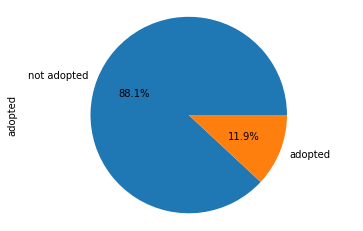

In [72]:
print(format(df.adopted.sum()/df.adopted.count()*100,'1.1f'), '% of observed users were adopted')
_ = df.adopted.value_counts().plot(kind='pie',labels=['not adopted','adopted'],autopct='%1.1f%%')
_ = plt.axis('equal')

Only 11.9% of users were adopted, showing a pretty significant class imbalance that will need to be addressed later! For now, we will split the data into X (features) and y (target) variables.

In [73]:
#Split data into X and y
X = df.drop(['adopted'],axis=1)
y = df['adopted']

## Final Multicollinearity Analysis

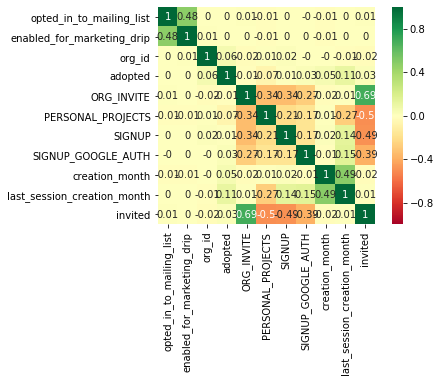

In [74]:
#Correlation matrix
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

The correlation matrix shows that last_session creation_month has the strongest direct, linear correation with adopted (0.22). None of the other columns have a correlation factor greater than 0.7 so no multicollinearity is evident from this matrix. We will not look at the variance inflation factors to confirm.

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
9,5.706871,invited
5,1.995989,SIGNUP
4,1.934526,PERSONAL_PROJECTS
3,1.915684,ORG_INVITE
6,1.655964,SIGNUP_GOOGLE_AUTH


Since all the VIFs are less than 10, it doesn't look like we have much multicollinearity present in our data. We're good to move forward with our machine learning model to identify the important features!

# Machine Learning

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Remember the significant class imbalance that exists in our data, with only 11.9% of users being adopted? To combat this, we will oversample the training data to balance out the classes. Over-sampling will increase the number of adopted users in our data to (hopefully) close to a 50:50 ratio. To do this, we will use SMOTE (Synthetic Minority Over-Sampling Technique) which creates new (synthetic) observations based on the observations in our data.

In [83]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 7398), (1, 7398)]


We will use compare a RandomForestClassifier and a GradientBoostingClassifier - both have built-in feature importance generators based on the Gini coefficients.

## Random Forest Classifier

In [84]:
%%time

from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
rf.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_rf = rf.predict(X_test)

CPU times: user 1.77 s, sys: 24.2 ms, total: 1.8 s
Wall time: 1.79 s


In [85]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.95756
Test Accuracy: 0.94083
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3037          133
Actual 1           80          350
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3170
           1       0.72      0.81      0.77       430

    accuracy                           0.94      3600
   macro avg       0.85      0.89      0.87      3600
weighted avg       0.94      0.94      0.94      3600



## Gradient Boosting Classifier

In [86]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

# instantiate model to run 50 estimators
gb = GradientBoostingClassifier(random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_gb = cross_val_score(gb, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
gb.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_gb = gb.predict(X_test)

CPU times: user 3 s, sys: 24.6 ms, total: 3.02 s
Wall time: 3.02 s


In [87]:
print("Train Accuracy:",format(np.mean(cv_accuracy_gb),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_gb),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_gb),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_gb))

Train Accuracy: 0.94211
Test Accuracy: 0.93528
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         2998          172
Actual 1           61          369
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3170
           1       0.68      0.86      0.76       430

    accuracy                           0.94      3600
   macro avg       0.83      0.90      0.86      3600
weighted avg       0.94      0.94      0.94      3600



Both Random Forest and Gradient Boosting classifiers provide good training and test accuracies of about 94-95%. The f-1 score is 0.97 for the "not adopted" class and 0.78 for the "adopted class. The gradient boosting classifier results in slightly less overfitting and slightly higher f-1 score for the adopted class so we will use the GB model to determine feature importance.

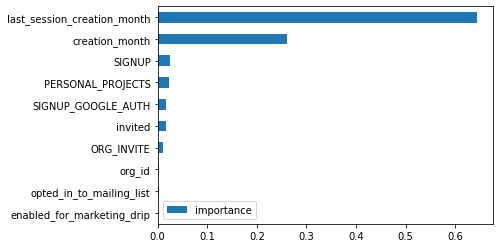

In [88]:
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

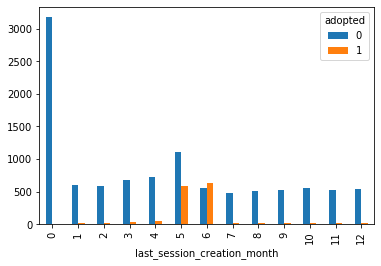

In [89]:
pd.crosstab(df.last_session_creation_month,df.adopted).plot(kind='bar')